In [2]:
import os
import glob
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage.filters import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
%matplotlib inline
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)

In [5]:
stim_path = "data/LargeRandNet/LargeRandNet_cosinput.csv"
response_path = "data/LargeRandNet/LargeRandNet_SpikeTime.csv"

# Load Data
stimulus = np.loadtxt(stim_path, delimiter=',')
df = pd.read_csv(response_path, names=['Time', 'ID'])
df['Time'] = df['Time'].round(4)
df['Trial'] = df['Time'].apply(lambda x: x // 100 + 1).astype(int)
df['Time'] = df['Time'].apply(lambda x: x - ((x // 100) * 100)).round(2)

12/09/2022 07:04:55 - WARNING - matplotlib.font_manager -   findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
12/09/2022 07:04:55 - WARNING - matplotlib.font_manager -   findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans


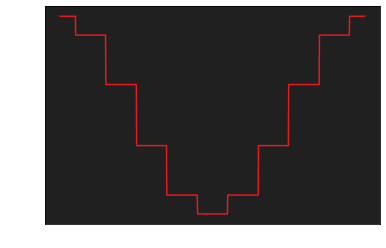

In [6]:
plt.plot(stimulus[0, :,])

In [7]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
frame_window = 20
window = 10
window_prev = 10
dt = 0.1

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_2'] = make_intervals(df, window_prev)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]

In [8]:
df

,Time,ID,Trial,Interval
0,2.2,855.0,1,10.0
1,3.1,959.0,1,10.0
2,3.2,922.0,1,10.0
3,3.5,972.0,1,10.0
4,3.7,142.0,1,10.0
...,...,...,...,...
882780,98.6,19.0,500,100.0
882781,98.7,94.0,500,100.0
882782,98.8,52.0,500,100.0
882783,98.9,78.0,500,100.0


In [9]:
from SpikeVidUtils import SpikeTimeVidData2

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
n_embd = 64
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
frame_block_size = 1000  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = 256

# frame_block_size = 560
prev_id_block_size = 30
id_block_size = 30   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
# neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
neurons = sorted(list(set(df['ID'].unique())))
# pixels = sorted(np.unique(frames).tolist())
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

10.0

In [10]:
frame_block_size

1000

In [11]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

In [12]:
test_data

,Time,ID,Trial,Interval
705418,0.0,181.0,401,0.0
705419,0.3,21.0,401,10.0
705420,0.4,108.0,401,10.0
705421,0.5,224.0,401,10.0
705422,0.7,89.0,401,10.0
...,...,...,...,...
882780,98.6,19.0,500,100.0
882781,98.7,94.0,500,100.0
882782,98.8,52.0,500,100.0
882783,98.9,78.0,500,100.0


In [13]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 30
frames: 1000, id: 30
0.0
Length: 177367 Neurons: 1003 Pixels: 0.
id block size: 30
frames: 1000, id: 30
0.0
train: 4000, test: 1000


In [14]:
from model_neuroformer_LRN import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
# for is_conv in [True, False]:    
conv_layer = True
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, sparse_topk_frame=None, sparse_topk_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=4, n_state_history_layers=4, n_stimulus_layers=8, self_att_layers=4,
                        n_layer=10, n_head=2, n_embd=n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt)  # 0.35
model = GPT(mconf)

64000


12/09/2022 07:04:56 - INFO - model_neuroformer_LRN -   number of parameters: 6.870765e+07


In [15]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 250
batch_size = 32 * 3
shuffle = True
model_path = f"/home/antonis/projects/slab/git/neuroformer/models/tensorboard/LRN/first_test/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_sparse{mconf.sparse_mask}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(n_dt)}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"
# model.load_state_dict(torch.load(model_path, map_location='cpu'))
# model.load_state_dict(torch.load("/Users/antonis/Downloads/[16, 17, 18, 19]_Cont_True_0.50.05_sparseFalse_conv_True_shuffle_True_batch_224_sparse_(None_None)_pos_emb_False_temp_emb_True_drop_0.2_dt_True_2.0_0.5_max0.05_(4, 0, 6)_2_256_nembframe64-2.pt", map_location='cpu'))

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=4e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e5, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False)
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")


trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()  

In [16]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

iterable = iter(train_dataset)

Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 30
frames: 1000, id: 30
0.0
Length: 177367 Neurons: 1003 Pixels: 0.
id block size: 30
frames: 1000, id: 30
0.0
train: 4000, test: 1000


In [17]:
loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, pin_memory=True)
iterable = iter(loader)

In [ ]:
x, y = next(iterable)
model(x)